In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, Lambda, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Model, optimizers, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load dataset

In [3]:
!gdown 'https://drive.google.com/uc?export=download&id=1phWikkOYex57DGxgNv3PgkF0pQ9Nsm1a'
!gdown 'https://drive.google.com/uc?export=download&id=1ykhOpo8ZjgDfbQ2CdR-zN-X_T8WEtL00'
!gdown 'https://drive.google.com/uc?export=download&id=1hzhmO5ZK_aVHUfGeWf3s4bHQPyl5EzUJ'

Downloading...
From: https://drive.google.com/uc?export=download&id=1phWikkOYex57DGxgNv3PgkF0pQ9Nsm1a
To: /content/Handwritten_V2_train.csv
100% 35.3M/35.3M [00:00<00:00, 183MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1ykhOpo8ZjgDfbQ2CdR-zN-X_T8WEtL00
To: /content/Handwritten_V2_valid.csv
100% 11.7M/11.7M [00:00<00:00, 40.3MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1hzhmO5ZK_aVHUfGeWf3s4bHQPyl5EzUJ
To: /content/Handwritten_V2_test.csv
100% 13.0M/13.0M [00:00<00:00, 49.6MB/s]


In [4]:
train = pd.read_csv("Handwritten_V2_train.csv")
test = pd.read_csv("Handwritten_V2_test.csv")
validate = pd.read_csv("Handwritten_V2_valid.csv")

#### Split dataset into train, test, validate

In [5]:
train_images = train.iloc[:, 1:].values
test_images = test.iloc[:, 1:].values
train_labels = train.iloc[:, 0].values
test_labels = test.iloc[:, 0].values
validate_labels = validate.iloc[:, 0].values
validate_images = validate.iloc[:, 1:].values

#### Classes

In [6]:
np.unique(train_labels)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85])

In [7]:
num_classes = 85

#### Reshape to 32 x 32 with 3 channels

In [8]:
train_images = np.concatenate([train_images.reshape(-1, 32, 32, 1)] * 3, axis=-1)
test_images = np.concatenate([test_images.reshape(-1, 32, 32, 1)] * 3, axis=-1)
validate_images = np.concatenate([validate_images.reshape(-1, 32, 32, 1)] * 3, axis=-1)

In [38]:
print("train shape: ",train_images.shape, "test shape: ", test_images.shape, "validate shape: ", validate_images.shape)

train shape:  (17235, 32, 32, 3) test shape:  (6359, 32, 32, 3) validate shape:  (5705, 32, 32, 3)


### Data Augmentation

In [12]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)
#train_generator = gen.flow(train_images, train_labels, batch_size=32)

In [13]:
target_per_class = 250
augmented_images = []
augmented_labels = []

In [15]:
for class_idx in range(1, num_classes+1):
    Xc = train_images[train_labels == class_idx]
    print(f"Class {class_idx}: found {Xc.shape[0]} images")
    if Xc.shape[0] == 0:
      continue
    count = Xc.shape[0]
    # Determine how many new images are needed for this class
    need = target_per_class - count
    if need <= 0:
        continue
    # Use flow to generate `need` augmented images for this class
    gen = datagen.flow(Xc, batch_size=1, shuffle=True)
    for _ in range(need):
        batch = next(gen)
        img = batch[0]
        augmented_images.append(img)
        augmented_labels.append(class_idx)

# Combine original and augmented data
x_aug = np.concatenate([train_images, np.array(augmented_images)], axis=0)
y_aug = np.concatenate([train_labels, np.array(augmented_labels)], axis=0)
print(f"Augmented data shape: {x_aug.shape}, labels shape: {y_aug.shape}")

Class 1: found 179 images
Class 2: found 316 images
Class 3: found 192 images
Class 4: found 190 images
Class 5: found 180 images
Class 6: found 183 images
Class 7: found 175 images
Class 8: found 194 images
Class 9: found 204 images
Class 10: found 230 images
Class 11: found 171 images
Class 12: found 228 images
Class 13: found 191 images
Class 14: found 225 images
Class 15: found 234 images
Class 16: found 197 images
Class 17: found 220 images
Class 18: found 198 images
Class 19: found 250 images
Class 20: found 211 images
Class 21: found 202 images
Class 22: found 210 images
Class 23: found 201 images
Class 24: found 186 images
Class 25: found 198 images
Class 26: found 191 images
Class 27: found 205 images
Class 28: found 180 images
Class 29: found 200 images
Class 30: found 209 images
Class 31: found 190 images
Class 32: found 185 images
Class 33: found 197 images
Class 34: found 213 images
Class 35: found 213 images
Class 36: found 215 images
Class 37: found 207 images
Class 38: 

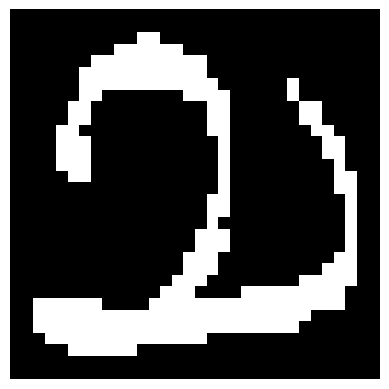

In [17]:
plt.imshow(x_aug[10000])
plt.axis('off')
plt.show()

## One hot encoding

Make labels from 0-84 for proper encoding

In [18]:
y_aug = np.array(y_aug) - 1
test_labels = np.array(test_labels) - 1
validate_labels = np.array(validate_labels) - 1

In [20]:
np.unique(y_aug)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84])

In [21]:
y_aug = to_categorical(y_aug, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)
validate_labels = to_categorical(validate_labels, num_classes=num_classes)

In [22]:
y_aug.shape

(25397, 85)

### MobileNet Model

In [23]:
base_model = MobileNetV3Small(input_shape=(32, 32, 3), include_top=False, weights='imagenet')

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


###Freezing the base model

In [24]:
base_model.trainable = False
for layer in base_model.layers[-3:]:
    layer.trainable = True

### Making trainable classifier

In [25]:
model = Sequential([base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    Dense(85, activation='softmax')])

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 1, 1, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 85)             │        49,045 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 988,165 (3.77 MB)

 Trainable params: 105,493 (412.08 KB)

 Non-trainable params: 882,672 (3.37 MB)

### Training the model

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
epochs = 10

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='malayalam_mobilenetv3.keras',
        save_best_only=True,
        monitor='val_accuracy'
    ),
    tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    restore_best_weights=True
    )
]

In [31]:
history = model.fit(x_aug, y_aug,
                    epochs=epochs,
                    validation_data=(validate_images, validate_labels),
                    callbacks=callbacks,
)

Epoch 1/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.1777 - loss: 3.8971 - val_accuracy: 0.0252 - val_loss: 4.5102
Epoch 2/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.3699 - loss: 2.6185 - val_accuracy: 0.0186 - val_loss: 4.4718
Epoch 3/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.4213 - loss: 2.3643 - val_accuracy: 0.0223 - val_loss: 4.4667
Epoch 4/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.4645 - loss: 2.1912 - val_accuracy: 0.0133 - val_loss: 4.4653
Epoch 5/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4739 - loss: 2.1178 - val_accuracy: 0.0319 - val_loss: 4.3359
Epoch 6/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.4892 - loss: 2.0765 - val_accuracy: 0.0613 - val_loss: 4.3063
Epoch 7/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.4932 - loss: 2.0432 - val_accuracy: 0.1018 - val_loss: 4.4049
Epoch 8/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.5007 - loss: 2.0116 - 

In [32]:
model.evaluate(test_images, test_labels)

199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1531 - loss: 9.4903


[10.9629545211792, 0.10253184288740158]

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
fine_history = model.fit(
    x_aug, y_aug,
    epochs=20,
    validation_data=(validate_images, validate_labels),
    initial_epoch=history.epoch[-1],
    callbacks=callbacks
)

Epoch 10/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.5496 - loss: 1.8351 - val_accuracy: 0.2617 - val_loss: 5.2037
Epoch 11/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.5726 - loss: 1.7631 - val_accuracy: 0.5630 - val_loss: 1.7584
Epoch 12/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.5804 - loss: 1.7365 - val_accuracy: 0.6156 - val_loss: 1.4299
Epoch 13/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.5820 - loss: 1.7282 - val_accuracy: 0.6521 - val_loss: 1.1901
Epoch 14/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.5871 - loss: 1.7107 - val_accuracy: 0.6037 - val_loss: 1.5300
Epoch 15/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.5848 - loss: 1.7191 - val_accuracy: 0.6882 - val_loss: 1.1210
Epoch 16/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.5947 - loss: 1.6910 - val_accuracy: 0.6680 - val_loss: 1.2095
Epoch 17/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.5932 - loss: 1

In [35]:
model.evaluate(test_images, test_labels)

199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6182 - loss: 1.6732


[1.8459993600845337, 0.5711590051651001]

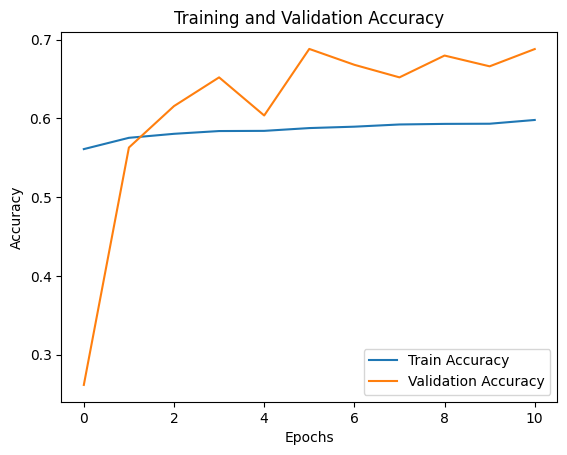

In [36]:
# Plot training history
plt.plot(fine_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [37]:
#model.save('malayalam_mobilenetv3.keras')